# PyTorch Workflow

1. Data - Preparation and Loading
2. Model - Building
3. Model - Fitting
4. Model - Predictions and Evaluation
5. Model - Saving and Loading
6. Summarization

In [157]:
import torch
from torch import nn # Contains PyTorch's building blocks for Neural Networks
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [158]:
torch.__version__

'2.4.0+cu121'

## 1. Data - Preparation and Loading

Types of data:

* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Main ML steps:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.


**Parameter:** It's what a model learns.

### Create data using Linear Regression formula

#### Create **known** parameters

These are the values that we are going to try to obtain:

In [159]:
weight = 0.7
bias = 0.3

In [160]:
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias # Linear Regression

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Splitting data into training and test set

In [161]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [162]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(8, 6))
  plt.scatter(train_data, train_labels, c="blue", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="green", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="red", s=4, label="Predicitons")

  plt.legend(prop={"size": 14})

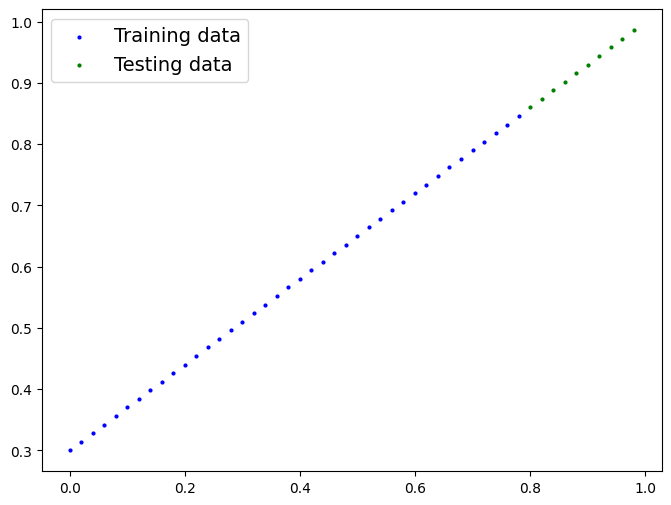

In [163]:
plot_predictions()

## 2. Build a Model

Linear Regression model example:

In [164]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # Linear Regression formula

### PyTorch model building essentials

* torch.nn - Building blocks for computational graphs (neural networks)
* torch.nn.Parameter - What parameters should our model try and learn. PyTorch layer takes care for us
* torch.nn.Module - Base class for all network modules (override forward method)
* toch.optim - Optimizations that help with gradient descent

### Checking the contents of our PyTorch model

We can use `.parameters()` to check out our model parameters.

In [165]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [166]:
list(model_0.state_dict())

['weights', 'bias']

## Making prediction using `torch.inference_mode()`

This turns off the gradient tracking. Essentially PyTorch disables tools that are only used during training consenquently boosts performance.
We will see how well it predicts `y_test` based on `X_test`.

In [167]:
with torch.inference_mode(): # Context manager
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [168]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

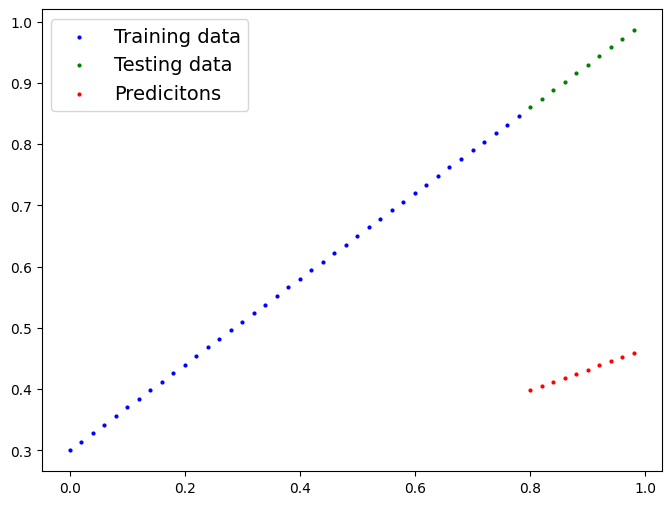

In [169]:
plot_predictions(predictions=y_preds)

## 3. Train Model

When dealing with models the aim is to move from some *unknown* parameters (these may be random) to *known* parameters.

A loss function (or cost function) is a way to measure how bad the model is.

**Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

**Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight and bias) to improve the loss function.

**OBS:** `torch.autograd` calculates the gradients automatically in order to find the parameters with the smallest loss values. This is done by the optimizer.

And specifically dor PyTorch, we need:
* A training loop
* A testing loop

 ### Setup a loss function

In [170]:
loss_fn = nn.L1Loss()

### Setup an optimizer

In [171]:
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # Most important hyperparameter, the step taken in the random value (change in the parameter, when giding the minimum value in the loss graph)

## PyTorch training loop

For the training loop, we'll build the following steps:

| Number | Step name                               | What does it do?                                                                                                                             | Code example                  |
|--------|-----------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------|
| 1      | Forward pass                            | The model goes through all of the training data once, performing its `forward()` function calculations.                                        | `model(x_train)`              |
| 2      | Calculate the loss                      | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.                                    | `loss = loss_fn(y_pred, y_train)` |
| 3      | Zero gradients                          | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.         | `optimizer.zero_grad()`        |
| 4      | Perform backpropagation on the loss     | Computes the gradient of the loss with respect to every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropagation, hence "backwards". | `loss.backward()`              |
| 5      | Update the optimizer (gradient descent) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them.                                   | `optimizer.step()`             |


In [172]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

In [173]:
model_0.state_dict() # We don't know the values that we need to get closer to in real life problems

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

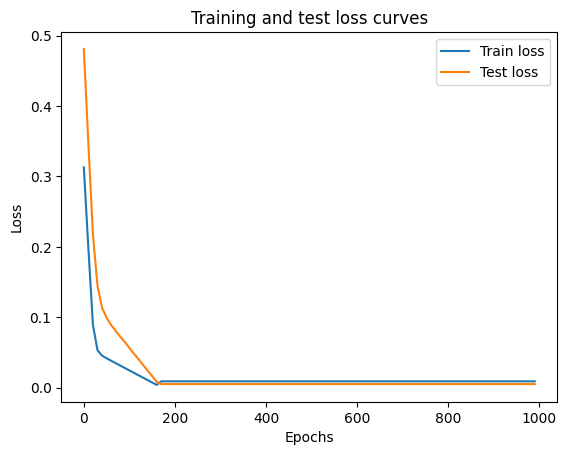

In [174]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

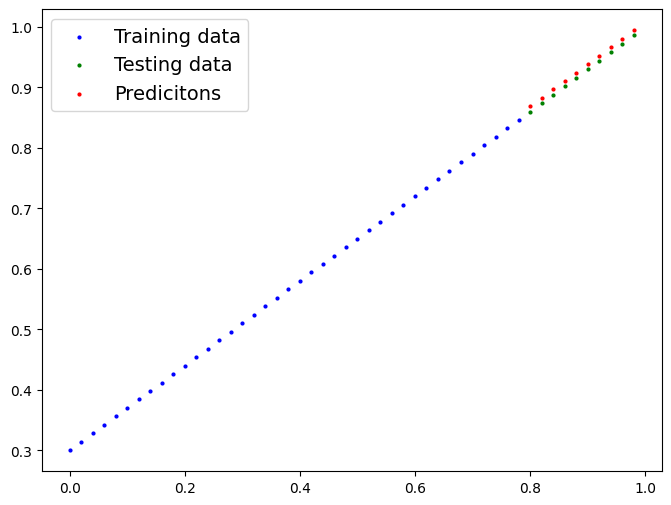

In [175]:
plot_predictions(predictions=test_pred)

## Saving a model in PyTorch

Main methods:
1. `torch.save()` - Saves PyTorch objects in Python's pickle format.
2. `torch.load()` - Loads a saved Pytorch objec.
3. `torch.nn.Module.load_state_dict()` - Loads a model's saved state dictionary.

In [176]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

### Saving

In [177]:
MODEL_PATH = Path("models")

MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH / "01_model_0.pth"

torch.save(model_0.state_dict(), MODEL_SAVE_PATH) # Use .pt or .pth for PyTorch

### Loading

In [178]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<ipython-input-178-656357b12263>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [179]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [180]:
# Making predictions
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [181]:
model_0.eval()

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [182]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [183]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [184]:
# Create some data using linear regression
weight = 0.7
bias = 0.3

# Create rage values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [185]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

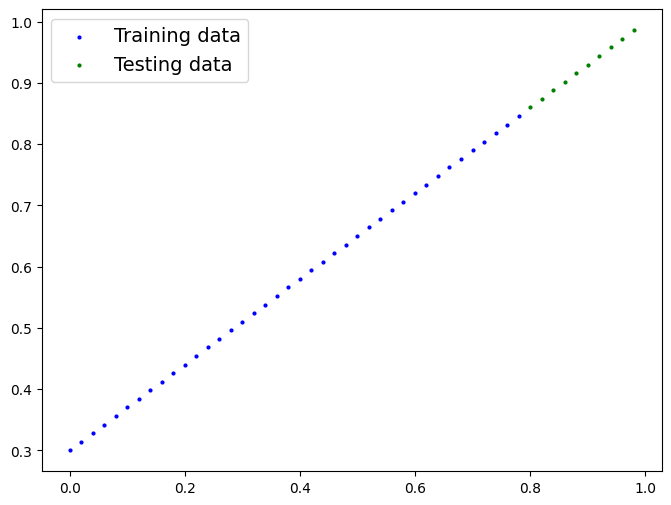

In [186]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch linear model

In [187]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters (aka linear transform, probing layer, fully connected layer, dense layer)
    self.linear_layer = nn.Linear(in_features=1,
                                 out_features=1) # Says that we will take one feature to output one feature

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [188]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### 6.3 Training a model

What we need:
* Loss function
* Optimizer
* Training Loop
* Testing Loop

In [189]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [190]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [191]:
# Setup loss function
loss_fn = nn.L1Loss() # Same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.001)

In [192]:
# Training loop
torch.manual_seed(42)

epochs = 2000

# Put data on the darget device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_1(X_train)

  # 2. Calculate the loss (how different are our models predictions to the ground truth)
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad of the optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()

  # Put the model in evaluation mode
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5861001014709473
Epoch: 100 | Loss: 0.4399694502353668 | Test loss: 0.4513919949531555
Epoch: 200 | Loss: 0.3247610330581665 | Test loss: 0.31668388843536377
Epoch: 300 | Loss: 0.209552600979805 | Test loss: 0.18197579681873322
Epoch: 400 | Loss: 0.09434414654970169 | Test loss: 0.04726768285036087
Epoch: 500 | Loss: 0.024156799539923668 | Test loss: 0.044561710208654404
Epoch: 600 | Loss: 0.019893135875463486 | Test loss: 0.046012092381715775
Epoch: 700 | Loss: 0.016448119655251503 | Test loss: 0.03835631161928177
Epoch: 800 | Loss: 0.013014188967645168 | Test loss: 0.030357254669070244
Epoch: 900 | Loss: 0.009578976780176163 | Test loss: 0.022289562970399857
Epoch: 1000 | Loss: 0.006145037245005369 | Test loss: 0.01429052371531725
Epoch: 1100 | Loss: 0.0027104676701128483 | Test loss: 0.006257164757698774
Epoch: 1200 | Loss: 0.0007765308255329728 | Test loss: 0.000619995582383126
Epoch: 1300 | Loss: 0.0007765308255329728 | Test loss:

In [193]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6999]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3008], device='cuda:0'))])

### 6.4 Making and evaluating predictions

In [194]:
# Turn model into evaluation mode
model_1.eval()

# Making predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8607],
        [0.8747],
        [0.8887],
        [0.9027],
        [0.9167],
        [0.9307],
        [0.9447],
        [0.9587],
        [0.9727],
        [0.9867]], device='cuda:0')

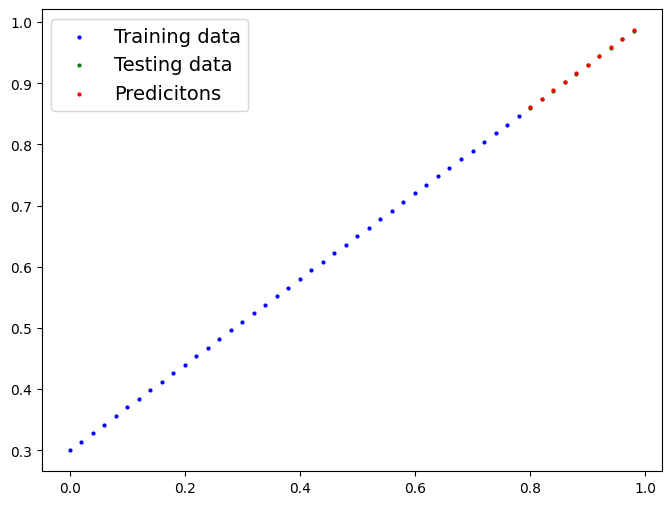

In [195]:
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving & loading a trained model

In [198]:
MODEL_PATH = Path("models")

MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH / "01_model_1.pth"

torch.save(model_1.state_dict(), MODEL_SAVE_PATH) # Use .pt or .pth for PyTorch

In [199]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

<ipython-input-199-de27d10e02fb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [200]:
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [201]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [202]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6999]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3008], device='cuda:0'))])

In [203]:
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

loaded_model_1_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')